##### Copyright 2018 The TensorFlow Authors.



In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Load text with tf.data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/alpha/tutorials/load_data/text"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial provides an example of how to use `tf.data.Dataset` to load examples from text files. It will also cover preprocessing and preparing text to be usable in a model. Finally, we'll do basic sentiment analysis, classifying each text example as "positive" or "negative." The text examples are movie reviews from IMDB.

## Setup

In [1]:
!pip install tensorflow==2.0.0-alpha0

    100% |████████████████████████████████| 79.9MB 169kB/s 
    100% |████████████████████████████████| 3.0MB 8.7MB/s 
    100% |████████████████████████████████| 61kB 20.9MB/s 
    100% |████████████████████████████████| 419kB 16.5MB/s 
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [0]:
from __future__ import absolute_import, division, print_function 

import os
import time

import numpy as np
import tensorflow as tf


This tutorial shows you how to load text into a TensorFlow dataset. So, before we begin, we're going to download and extract the text examples into a local directory.



In [3]:
DATA_URL = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

file = 'aclImdb_v1.tar.gz'
file = tf.keras.utils.get_file(file, DATA_URL, extract=True)
path = os.path.join(os.path.dirname(file), 'aclImdb')

84140032/84125825 [==============================] - 2s 0us/step


## Make text files available to Python

In the local directory, examples are split into `train` and `test` directories. Within each of those, positive reviews will be in a directory called `pos`, and negative ones in a directory called `neg`.

Your text data is probably organized differently than this, and may be in a database or other format. The important thing to notice in this step is making the text files available in a Python iterable. In this example, the iterable is a list of file names.

In [0]:
train_files = [
    os.path.join(path, 'train', label, '*') for label in ['pos', 'neg']
]
test_files = [
    os.path.join(path, 'test', label, '*') for label in ['pos', 'neg']
]

## Create TensorFlow datasets

We need to turn a bunch of files into labeled data. 

The original dataTo do this:

1. Use `tf.data.Dataset.list_files` to create a Dataset of file names.
2. Use `tf.data.Dataset.flat_map` to iterate through each file name and:

  a. Label the item `1` for positive or `0` for negative.
  
  b. Load the text from the file with `tf.data.TextLineDataset`.
  
  c. Combine the label with the text data using `tf.data.Dataset.zip`.

Apply this process to both the training data files and the test data files.


In [0]:
def get_labeled_dataset(patterns):

  files = tf.data.Dataset.list_files(patterns).shuffle(len(patterns))
  
  # Maps a filename to a dataset that produces (review, sentiment) pair.
  def flat_map_fn(filename):
    label = tf.data.Dataset.from_tensors(
        tf.cast(tf.strings.regex_full_match(filename, '^.*pos.*$'), tf.float64))
    return tf.data.Dataset.zip((tf.data.TextLineDataset(filename), label))

  
  return files.flat_map(flat_map_fn)

train_data = get_labeled_dataset(train_files)
test_data = get_labeled_dataset(test_files)

## Build a vocabulary

There are many ways to represent text data for input into a machine learning model. For this tutorial, the text of each review will be represented as a list of integers, with each integer representing a single unique word.

The first step to doing this is to create a map of unique words to integers. This mapping will be called the `vocabulary`, and will be a Python dictionary with words as keys and integer Tensors as values.

To build the vocabulary:

1. Use `tf.data.Dataset.map` to tokenize each example:

  a. Remove punctuation and other non-word characters from the text examples.
  
  b. Split them into arrays of tokens (word-like substrings).

2. Create a new dataset in which each element is a token from the text data.

3. Remove duplicates eith `tf.data.experimental.unique`.

4. Assign a unique integer to each token with `tf.data.experimental.Counter`.

5. Create a Python dictionary in which the keys are tokens and the values are integer tensors.

In [29]:
def tokenize(line):
  # Replace line breaks with spaces.
  line = tf.strings.regex_replace(line, r'\<br \/\>', ' ')
  # Replace punctuation with spaces.
  line = tf.strings.regex_replace(line, r'\W', ' ')
  tokens = tf.strings.split([line], sep=" ").values
  return tokens


def get_vocabulary(dataset):
  dataset = dataset.map(lambda example, label: tokenize(example))
  dataset = dataset.flat_map(tf.data.Dataset.from_tensor_slices)
  dataset = dataset.apply(tf.data.experimental.unique())
  dataset = tf.data.Dataset.zip((dataset, tf.data.experimental.Counter(start=1)))

  vocabulary = {}
  for word, index in iter(dataset):
    vocabulary[word.numpy()] = index
  return vocabulary

vocabulary = get_vocabulary(train_data.concatenate(test_data))


print(len(vocabulary)) # the number of unique tokens

129672


In [0]:
# shorten get_vocabulary to not produce a dictionary?

In [31]:
ds = test_data.map(tokenize).flat_map(tf.data.Dataset.from_tensor_slices.apply(tf.data.experimental.unique())



SyntaxError: ignored

In [32]:
ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [10]:
next(iter(ds))

<tf.Tensor: id=389332, shape=(), dtype=string, numpy='Rowan'>

In [0]:

ds_init = tf.lookup.KeyValueTensorInitializer(list(vocabulary.keys()), list(vocabulary.values()), tf.string)





In [0]:
ds_table = tf.lookup.StaticVocabularyTable(ds_init, 1)

In [13]:
ds_table.lookup(tf.constant(['I', 'hated', 'this', 'movie']))

<tf.Tensor: id=389346, shape=(4,), dtype=int64, numpy=array([   8, 4012,   73,   96])>

In [0]:
ex = next(iter(train_data))

In [18]:
ex[0]

<tf.Tensor: id=464356, shape=(), dtype=string, numpy="That's right, you heard me. I am a huge fan of James Patterson. I own 10 of his books, and I have read the entire series about Lindsey Boxer. In my opinion, the screenwriter should be shot. <br /><br />What right did any film maker have to slaughter a terrific work of fiction and make it into a mockery of the mystery genre? If I ever thought that Harry Potter was butchered, then Michael O'Hara has proved me wrong. <br /><br />I can only pray that the next screenwriter who tackles this fabulous book will do it a great deal more justice. To Michael O'Hara and Russell Mulcahy: don't quit your day job.">

In [0]:
ex_tokenized = tokenize(ex[0].numpy(), _)

In [26]:
ds_table.lookup(ex_tokenized[0])

<tf.Tensor: id=464385, shape=(130,), dtype=int64, numpy=
array([ 1,  2,  3,  4,  5,  6,  7,  4,  8,  9, 10, 11, 12, 13, 14, 15,  4,
        8, 16, 17, 13, 18, 19,  4, 20,  8, 21, 22, 23, 24, 25, 26, 27, 28,
        4, 29, 30, 31,  4, 23, 32, 33, 34, 35,  4,  4,  4, 36,  3, 37, 38,
       39, 40, 21, 41, 42, 10, 43, 44, 13, 45, 20, 46, 47, 48, 10, 49, 13,
       23, 50, 51,  4, 52,  8, 53, 54, 55, 56, 57, 58, 59,  4, 60, 61, 62,
       63, 64, 65,  7, 66,  4,  4,  4,  8, 67, 68, 69, 55, 23, 70, 32, 71,
       72, 73, 74, 75, 76, 77, 47, 10, 78, 79, 80, 81,  4, 82, 61, 62, 63,
       20, 83, 84,  4, 85, 86, 87, 88, 89, 90,  4])>

## Turn text datasets into integer datasets

Now that we have a numbered vocabulary, we can encode each review as a Tensor of integers representing words.

Each input Tensor needs to be the same length. So, first determine the length of the longest review. Then, tokenize the examples and encode them as a lists of integers, with a padding of zeroes to make all examples the same length.




In [14]:
BATCH_SIZE = 512
MAX_LEN = max([len(ex[0].numpy().split(" ")) for ex in train_data])
MAX_LEN

2470

In [0]:
vectorized_train_data = train_data.map(lambda example, label: )

In [0]:


def get_int_encoded_dataset(vocabulary, dataset):

  def encode_and_pad(tokenized_text, label):

    def helper(tokenized_text):
      tokenized_text = tokenized_text.numpy()
      result = []
      for word in tokenized_text:
        result.append(vocabulary[word])
      return tf.pad(result, [[0, MAX_LEN - len(result)]], 'CONSTANT')

    return tf.py_function(helper, [tokenized_text], tf.int64), label

  dataset = dataset.map(tokenize)
  dataset = dataset.map(encode_and_pad)
  dataset = dataset.shuffle(10 * BATCH_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  return dataset

train_data = get_int_encoded_dataset(vocabulary, train_data)


# THINGS TO TRY
# ragged tensor
# padded batch
# bucket by sequence length
# feature columns

In [0]:
text_batch,label_batch = next(iter(train_data))

In [0]:
text_batch

<tf.Tensor: id=1753688, shape=(512, 2470), dtype=int64, numpy=
array([[  321,    85,   510, ...,     0,     0,     0],
       [  421,   325,  4682, ...,     0,     0,     0],
       [    0,   187,    85, ...,     0,     0,     0],
       ...,
       [ 1481,    11, 10541, ...,     0,     0,     0],
       [  242, 10129,     6, ...,     0,     0,     0],
       [ 6043,   245,   372, ...,     0,     0,     0]])>

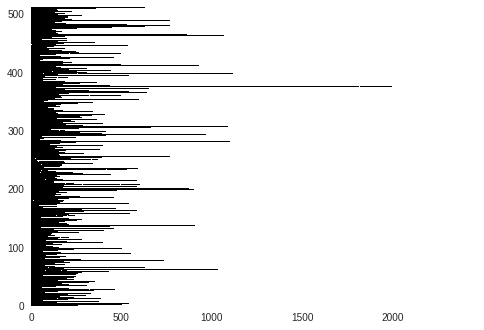

In [0]:
import matplotlib.pyplot as plt

plt.pcolormesh(text_batch.numpy() != 0)

In [0]:










def get_model(input_dim, embedding_dim=50, hidden_units=[100]):
  """Create a Keras Sequential model with layers.

  Args:
    input_dim: (int) Input dimensions for input layer.
    embedding_dim: (int) Embedding dimension for embedding layer.
    hidden_units: [int] the layer sizes of the DNN (input layer first)

  Returns:
    A Keras model.
  """

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(input_dim=input_dim,
                                      output_dim=embedding_dim,
                                      input_length=MAX_LEN))
  # convolutional layer or RNN
  model.add(tf.keras.layers.GlobalMaxPool1D())
  for units in hidden_units:
    model.add(tf.keras.layers.Dense(units, activation=tf.keras.backend.relu))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model










model = get_model(len(vocabulary))
model.fit(train_data, epochs=10)

test_data = get_indexed_dataset(vocabulary, test_files)
model.evaluate(test_data)


345418


W0321 22:29:00.914769 140374431422336 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/script_ops.py:476: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Epoch 1/10
49/49 [==============================] - 38s 769ms/step - loss: 0.6856 - accuracy: 0.5904
Epoch 2/10
49/49 [==============================] - 36s 744ms/step - loss: 0.5781 - accuracy: 0.8380
Epoch 3/10
49/49 [==============================] - 37s 749ms/step - loss: 0.3396 - accuracy: 0.8825
Epoch 4/10
49/49 [==============================] - 37s 750ms/step - loss: 0.1999 - accuracy: 0.9308
Epoch 5/10
49/49 [==============================] - 39s 800ms/step - loss: 0.1140 - accuracy: 0.9659
Epoch 6/10
49/49 [==============================] - 38s 771ms/step - loss: 0.0593 - accuracy: 0.9877
Epoch 7/10
49/49 [==============================] - 37s 765ms/step - loss: 0.0296 - accuracy: 0.9963
Epoch 8/10
49/49 [==============================] - 37s 757ms/step - loss: 0.0152 - accuracy: 0.9990
Epoch 9/10
49/49 [==============================] - 36s 743ms/step - loss: 0.0085 - accuracy: 0.9998
Epoch 10/10
49/49 [==============================] - 36s 742ms/step - loss: 0.0053 - accura

[0.37087987332927935, 0.85696]